### Importing Modules

In [2]:
# ML Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import TargetEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
df = pd.read_csv("./DataSet/cars24_car-price-clean-data.csv", index_col="Unnamed: 0")

In [4]:
df.columns

Index(['selling_price', 'make', 'model', 'year', 'seller_type', 'km_driven',
       'fuel_type', 'transmission_type', 'mileage', 'engine', 'max_power',
       'seats'],
      dtype='object')

In [5]:
categCols = ["make", "model", "seller_type", "fuel_type", "transmission_type", "seats"]
contCols = ["year", "km_driven", "mileage", "engine", "max_power"]

In [6]:
## splitting the Data to Train-Validation-Test

randomState = 50
## splitting the data to features and target Variables
X = df.drop(columns="selling_price")
y = df["selling_price"]

X_tr_vl, X_test, y_tr_vl, y_test = train_test_split(X, y, test_size=0.2, random_state=randomState)
X_train, X_val, y_train, y_val = train_test_split(X_tr_vl, y_tr_vl, test_size=0.25, random_state=randomState)

print("Training Data size: X: %s, y: %s" % (X_train.shape, y_train.shape))
print("Validation Data size: X: %s, y: %s" % (X_val.shape, y_val.shape))
print("Test Data size: X: %s, y: %s" % (X_test.shape, y_test.shape))

Training Data size: X: (11772, 11), y: (11772,)
Validation Data size: X: (3924, 11), y: (3924,)
Test Data size: X: (3925, 11), y: (3925,)


In [7]:
# Scaling Model Names
X_MinMaxModelName = "minmaxModel"
X_StdModelName = "stdModel"
X_TgtModelName = "tgtModel"

# Scaling Continuous Data
# TODO: Need to figure out which ones to pass to Standard Scaler and vice-versa 
minmax_features = []
standard_features = contCols
Target_features = categCols

# Create and fit model for continuous features
preprocessor = ColumnTransformer(
    transformers=[
        (X_MinMaxModelName, MinMaxScaler(), minmax_features),
        (X_StdModelName, StandardScaler(), standard_features),
        (X_TgtModelName, TargetEncoder(), Target_features)],
        remainder="passthrough")
preprocessor.fit(X=X_train, y=y_train)

# Create and fit model for Target Variable
yStdScaler = StandardScaler()
yStdScaler.fit(y_train.values.reshape(-1, 1))

StandardScaler()

In [8]:
# Saving the models for future use
# Model pickle file Names
X_MinMax_scale_pkl = "./Artifacts/X_MinMax_scale.pkl" 
X_Std_scale_pkl = "./Artifacts/X_Std_scale.pkl" 
X_Tgt_encode_pkl = "./Artifacts/X_Tgt_encode.pkl" 
y_Std_scale_pkl = "./Artifacts/y_Std_scale.pkl" 

with open(X_MinMax_scale_pkl, "wb") as pfile:
    pickle.dump(preprocessor.named_transformers_[X_MinMaxModelName], pfile)

with open(X_Std_scale_pkl, "wb") as pfile:
    pickle.dump(preprocessor.named_transformers_[X_StdModelName], pfile)

with open(X_Tgt_encode_pkl, "wb") as pfile:
    pickle.dump(preprocessor.named_transformers_[X_TgtModelName], pfile)

with open(y_Std_scale_pkl, "wb") as pfile:
    pickle.dump(yStdScaler, pfile)

In [9]:
## now transforming the continuous Features
X_train_scaled = pd.DataFrame(preprocessor.transform(X_train), columns = preprocessor.get_feature_names_out())
y_train_scaled = yStdScaler.transform(y_train.values.reshape(-1, 1))

X_val_scaled = pd.DataFrame(preprocessor.transform(X_val), columns = preprocessor.get_feature_names_out())
y_val_scaled = yStdScaler.transform(y_val.values.reshape(-1, 1))

X_test_scaled = pd.DataFrame(preprocessor.transform(X_test), columns = preprocessor.get_feature_names_out())
y_test_scaled = yStdScaler.transform(y_test.values.reshape(-1, 1))

### Create and tune the LR model

In [10]:
## adjusted R2 Formula

def adjusted_r2_score(X, y, ypred):
    ss_res = np.sum((y-ypred)**2)
    ss_mean = np.sum((y-y.mean())**2)
    m, d = X.shape
    r2 = 1 - ss_res/ss_mean
    adjusted_r2_score = 1-(((1-r2) * (m -1))/(m-d-1))
    
    return adjusted_r2_score

In [11]:
## Basic LR model.
lrModel = LinearRegression()
lrModel.fit(X_train_scaled, y_train_scaled)

LinearRegression()

In [12]:
yPred = lrModel.predict(X_val_scaled)

In [13]:
print("R2:")
print("\t - Training Score: ", lrModel.score(X_train_scaled, y_train_scaled))
print("\t - Validation Score: ", lrModel.score(X_val_scaled, y_val_scaled))
print("Adjusted R2:")
print("\t - Training Score: ", adjusted_r2_score(X_train_scaled,y_train_scaled,lrModel.predict(X_train_scaled)))
print("\t - Validation Score: ", adjusted_r2_score(X_val_scaled,y_val_scaled,lrModel.predict(X_val_scaled)))


R2:
	 - Training Score:  0.9255024889717118
	 - Validation Score:  0.7671921700666988
Adjusted R2:
	 - Training Score:  0.925432805925682
	 - Validation Score:  0.7665375468230213


We can see that there is a large difference between Training score and Validation score.

### OLS Model

In [14]:
# Understanding the data using OLS model
smOLS_X = sm.add_constant(X_train_scaled)
smOLS_y = y_train_scaled

olsModel = sm.OLS(endog=smOLS_y, exog=smOLS_X)
results = olsModel.fit()
display(results.summary())


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                 1.328e+04
Date:                Sat, 19 Oct 2024   Prob (F-statistic):               0.00
Time:                        20:17:01   Log-Likelihood:                -1417.9
No. Observations:               11772   AIC:                             2860.
Df Residuals:                   11760   BIC:                             2948.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -1.2253      0.026    -47.172      0.000      -1.276      -1.174
stdModel__year                 -0.0801      0.003    -24.419      0.000      -0.086      -0.074
stdModel__km_driven            -0.0288      0.003     -9.772      0.000      -0.035      -0.023
stdModel__mileage              -0.0222      0.004     -5.502      0.000      -0.030      -0.014
stdModel__engine                0.0026      0.006      0.435      0.664      -0.009       0.014
stdModel__max_power             0.0171      0.005      3.284      0.001       0.007       0.027
tgtModel__make                  0.0199      0.001     20.061      0.000       0.018       0.022
tgtModel__model                 0.1505      0.001    160.039      0.000       0.149       0.152
tgtModel__seller_type           0.0069      0.002      3.126      0.002       0.003       0.011
tgtModel__fuel_type             0.0090      0.002      4.670      0.000       0.005       0.013
tgtModel__transmission_type     0.0002      0.001      0.212      0.832      -0.002       0.002
tgtModel__seats                -0.0038      0.002     -1.707      0.088      -0.008       0.001
==============================================================================
Omnibus:                    10509.276   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1126786.111
Skew:                           3.842   Prob(JB):                         0.00
Kurtosis:                      50.309   Cond. No.                         182.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

OLS Models hypothesis
- H0: Features are not important and are useless.
- HA: Features are important

In [15]:
## trying to reduce the number of unwanted features using VIF
X_train_scaled.head(1)

vifData = pd.DataFrame({"columns": X_train_scaled.columns})
vifData["vif"] = [variance_inflation_factor(exog=X_train_scaled.values, exog_idx=idx) for idx in range(len(X_train_scaled.columns))]
print(vifData)

                        columns        vif
0                stdModel__year   1.696686
1           stdModel__km_driven   1.373477
2             stdModel__mileage   2.502300
3              stdModel__engine   4.383086
4           stdModel__max_power   4.256942
5                tgtModel__make   9.825664
6               tgtModel__model  10.516907
7         tgtModel__seller_type  24.802569
8           tgtModel__fuel_type  23.067464
9   tgtModel__transmission_type   8.207842
10              tgtModel__seats  23.773498


In [16]:
highestVIF = np.inf
VIFThreshold = 10
r2adjustedThreshold = 0.85
iter = 0
droppedCol = []
X_train_scaled_vifClean = X_train_scaled.copy()
while True:
    vifData = pd.DataFrame({"columns": X_train_scaled_vifClean.columns})
    vifData["vif"] = [variance_inflation_factor(exog=X_train_scaled_vifClean.values, exog_idx=idx) for idx in range(len(X_train_scaled_vifClean.columns))]
    maxIdx = vifData["vif"].idxmax()
    highestVIF = vifData.loc[maxIdx, "vif"]
    columntoDrop = vifData.loc[maxIdx, "columns"]
    
    smOLS_X = sm.add_constant(X_train_scaled_vifClean)
    smOLS_y = y_train_scaled
    olsModel = sm.OLS(endog=smOLS_y, exog=smOLS_X)
    results = olsModel.fit()

    if (highestVIF < VIFThreshold) or results.rsquared_adj < r2adjustedThreshold:
        print("Threshold Reached.!")
        print("highestVIF: ", highestVIF)
        print("adjusted-R2 ", results.rsquared_adj)
        print("dropped ColumnName: ", droppedCol)
        
        print("\n", results.summary())
        break
    else:
        print("iter: %d, VIF_Val: %d, ColumnName: %s" % (iter, highestVIF, columntoDrop))
        droppedCol.append(columntoDrop)
        X_train_scaled_vifClean.drop(columns=columntoDrop, inplace=True)
    
    iter += 1

iter: 0, VIF_Val: 24, ColumnName: tgtModel__seller_type
iter: 1, VIF_Val: 20, ColumnName: tgtModel__fuel_type
iter: 2, VIF_Val: 10, ColumnName: tgtModel__model
Threshold Reached.!
highestVIF:  7.212084471846789
adjusted-R2  0.7593497138342267
dropped ColumnName:  ['tgtModel__seller_type', 'tgtModel__fuel_type', 'tgtModel__model']

                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     4644.
Date:                Sat, 19 Oct 2024   Prob (F-statistic):               0.00
Time:                        20:17:01   Log-Likelihood:                -8315.7
No. Observations:               11772   AIC:                         1.665e+04
Df Residuals:                   11763   BIC:                         1.672e+04
Df Model:                         

In [17]:
## Refit the model with new dropped columns
## Basic LR model.
lrModel = LinearRegression()
lrModel.fit(X_train_scaled_vifClean, y_train_scaled)

yPred = lrModel.predict(X_val_scaled.drop(columns=droppedCol))

print("R2:")
print("\t - Training Score: ", lrModel.score(X_train_scaled_vifClean, y_train_scaled))
print("\t - Validation Score: ", lrModel.score(X_val_scaled.drop(columns=droppedCol), y_val_scaled))
print("Adjusted R2:")
print("\t - Training Score: ", adjusted_r2_score(X_train_scaled_vifClean, y_train_scaled, lrModel.predict(X_train_scaled_vifClean)))
print("\t - Validation Score: ", adjusted_r2_score(X_val_scaled.drop(columns=droppedCol), y_val_scaled, lrModel.predict(X_val_scaled.drop(columns=droppedCol))))

print("\nWe can see that the Model over-Fitting reduced drastically as we removed unwanted multi collinear features")


R2:
	 - Training Score:  0.7595132685270587
	 - Validation Score:  0.7506185549032974
Adjusted R2:
	 - Training Score:  0.7593497138342267
	 - Validation Score:  0.7501089631891791

We can see that the Model over-Fitting reduced drastically as we removed unwanted multi collinear features


Check fit of Linear Regression Tests
- Linear relation between features
- No multi-collinearity
- errors follow Normal Distribution
- Errors are homoeostatic

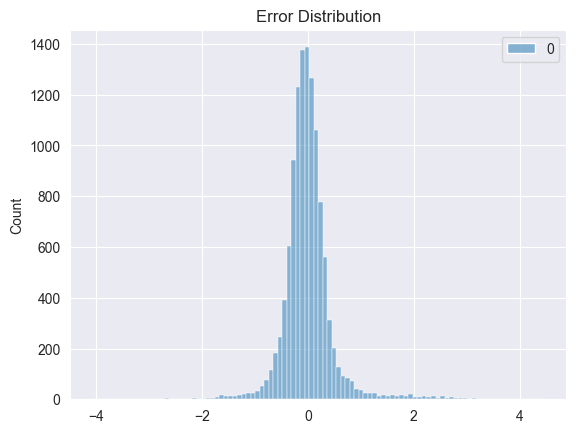

In [18]:
errors = y_train_scaled - lrModel.predict(X_train_scaled_vifClean)
sns.histplot(errors, bins=100)
plt.title("Error Distribution")
plt.show()

The Data looks like Normal Distributed

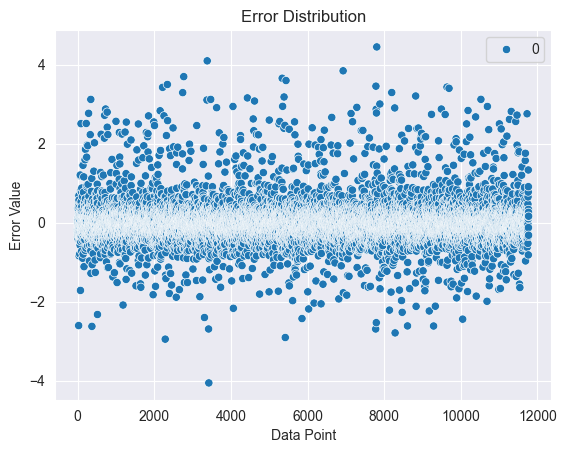

In [19]:
sns.scatterplot(errors)
plt.ylabel("Error Value")
plt.xlabel("Data Point")
plt.title("Error Distribution")
plt.show()

### Final Trial on TestData

In [23]:
print("R2:")
print("\t - Test Score: ", lrModel.score(X_test_scaled.drop(columns=droppedCol), y_test_scaled))
print("Adjusted R2:")
print("\t - Test Score: ", adjusted_r2_score(X_test_scaled.drop(columns=droppedCol), y_test_scaled, lrModel.predict(X_test_scaled.drop(columns=droppedCol))))

R2:
	 - Test Score:  0.7656176250922732
Adjusted R2:
	 - Test Score:  0.7651388051231052


In [21]:
X_Tgt_encode_pkl = "./Artifacts/lr_BasicModel.pkl"

with open(X_Tgt_encode_pkl, "wb") as pfile:
    pickle.dump(lrModel, pfile)